In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import NearestNeighbors
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN


import pandas
print("Pandas version:", pandas.__version__)


ModuleNotFoundError: No module named 'pandas'

 Ex. 1 In this exercise we verify numerically the purpose of the leverage scores discussed in class. Generate a random linear model y = ax1 + b + ϵ where ϵ is random Gaussian noise with mean µ and variance σ2. For various values of µ,σ2 generate data and compute the leverage scores for all the points. Create four types of points: regular (low noise, close to the model), high variance on x, high variance on y andfinally high variance on both x and y. Plot all results, group in subplots for the various values of noise variance. Mark on the plots the points with the highest leverage scores. Repeat the exercise for the 2D case y = ax1+bx2+c+ϵ.

In [7]:


a_1d = 2.0
b_1d = -1.0

a_2d = 1.5
b_2d = -0.75
c_2d = 0.5

sigmas = [0.1, 0.5, 1.5]


mu = 0.0


n_per_group = 80  

top_k = 8  


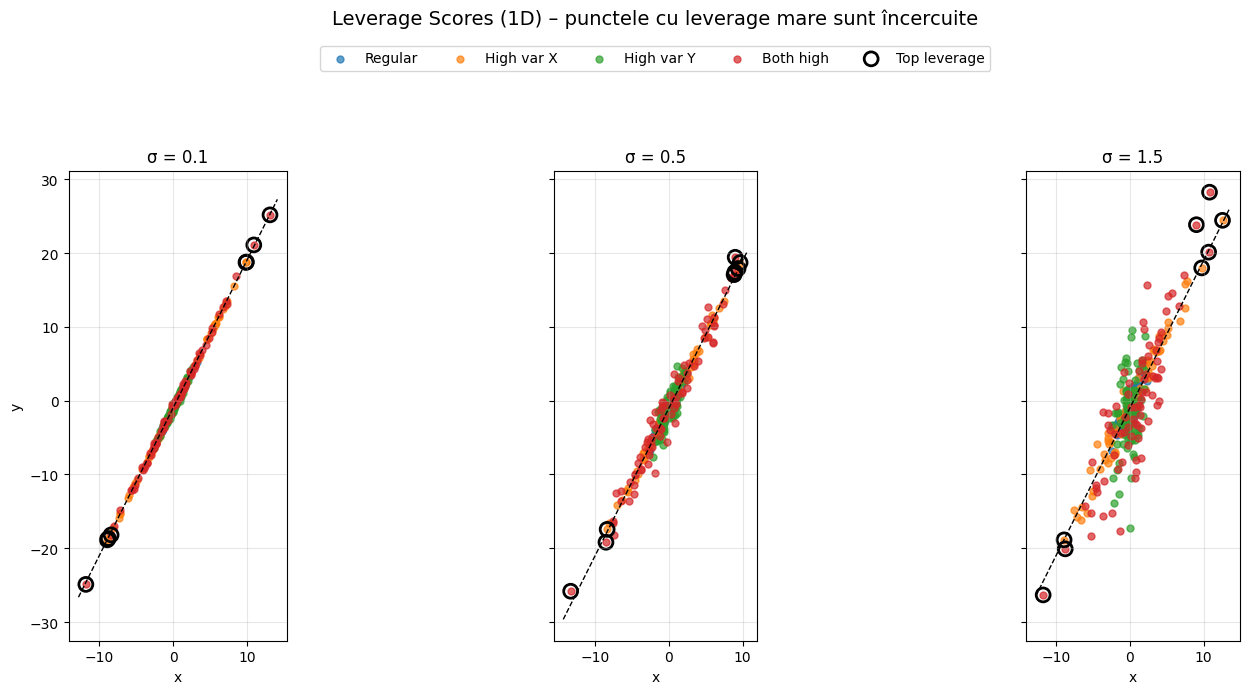

In [12]:
def generate_groups_1d(a, b, mu, sigma, n):
  
    x_reg = np.random.normal(0, 1, n)
    eps_reg = np.random.normal(mu, sigma, n)
    y_reg = a * x_reg + b + eps_reg
    reg = np.column_stack([x_reg, y_reg])

    
    x_hx = np.random.normal(0, 4, n)
    eps_hx = np.random.normal(mu, sigma, n)
    y_hx = a * x_hx + b + eps_hx
    hx = np.column_stack([x_hx, y_hx])

    
    x_hy = np.random.normal(0, 1, n)
    eps_hy = np.random.normal(mu, max(sigma * 3, 0.2), n)
    y_hy = a * x_hy + b + eps_hy
    hy = np.column_stack([x_hy, y_hy])

   
    x_both = np.random.normal(0, 4, n)
    eps_both = np.random.normal(mu, max(sigma * 3, 0.2), n)
    y_both = a * x_both + b + eps_both
    both = np.column_stack([x_both, y_both])

    return reg, hx, hy, both


def compute_leverage(X_vec):
   
    X_design = np.column_stack([np.ones_like(X_vec), X_vec])
    XtX_inv = np.linalg.inv(X_design.T @ X_design)
    H = X_design @ XtX_inv @ X_design.T
    return np.diag(H)


def plot_leverage_1d(sigmas, a, b, mu, n_per_group, top_k):
    fig, axes = plt.subplots(1, len(sigmas), figsize=(16, 6), sharey=True)
    if len(sigmas) == 1:
        axes = [axes]

    for j, sigma in enumerate(sigmas):
       
        reg, hx, hy, both = generate_groups_1d(a, b, mu, sigma, n_per_group)
        data = np.vstack([reg, hx, hy, both])
        X_vec, y_vec = data[:, 0], data[:, 1]

        leverage = compute_leverage(X_vec)
        top_idx = np.argsort(leverage)[-top_k:]

        
        ax = axes[j]
        ax.scatter(reg[:, 0], reg[:, 1], s=25, alpha=0.7, label="Regular")
        ax.scatter(hx[:, 0], hx[:, 1], s=25, alpha=0.7, label="High var X")
        ax.scatter(hy[:, 0], hy[:, 1], s=25, alpha=0.7, label="High var Y")
        ax.scatter(both[:, 0], both[:, 1], s=25, alpha=0.7, label="Both high")

        
        ax.scatter(X_vec[top_idx], y_vec[top_idx], 
                   s=100, facecolors='none', edgecolors='black', 
                   linewidths=2, label="Top leverage")

       
        xs = np.linspace(np.min(X_vec) - 1, np.max(X_vec) + 1, 200)
        ax.plot(xs, a * xs + b, 'k--', linewidth=1)

        ax.set_title(f"σ = {sigma}", fontsize=12)
        ax.set_xlabel("x")
        if j == 0:
            ax.set_ylabel("y")
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.1))
    fig.suptitle("Leverage Scores (1D) – punctele cu leverage mare sunt încercuite", y=1.15, fontsize=14)
    fig.tight_layout()
    plt.show()



plot_leverage_1d(sigmas, a_1d, b_1d, mu, n_per_group, top_k)

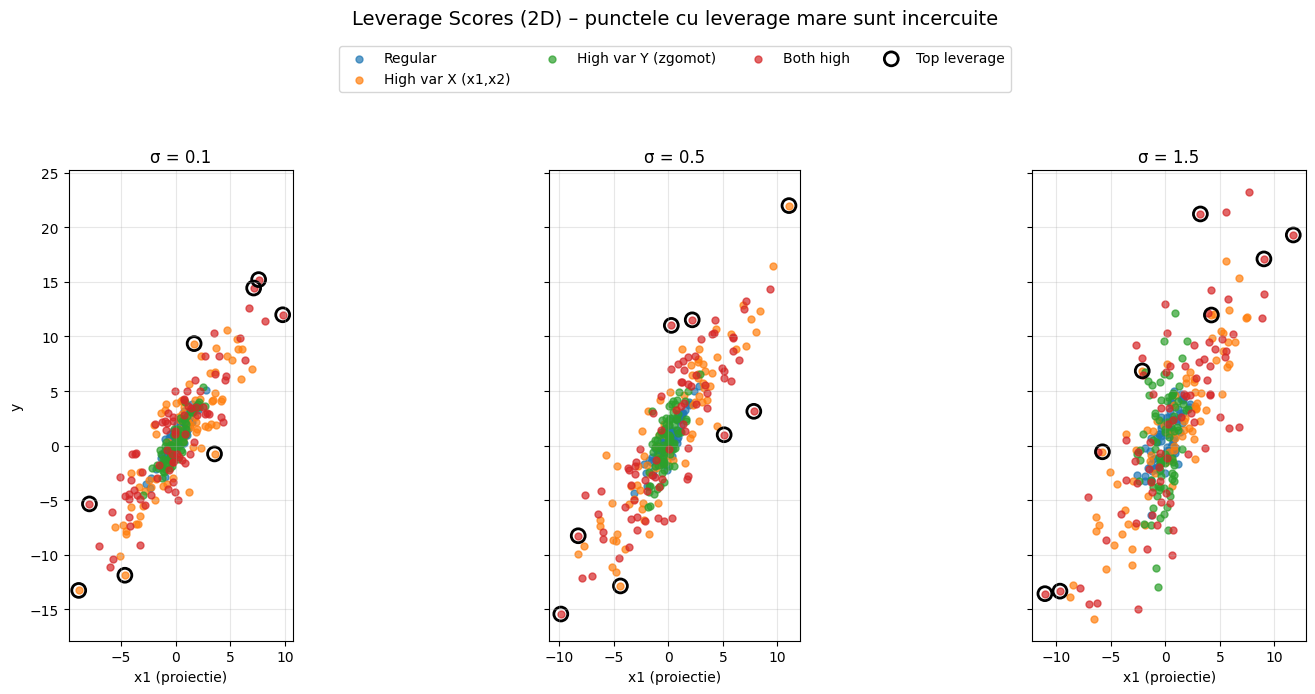

In [25]:

def generate_groups_2d(a, b, c, mu, sigma, n):
    
    x1_r = np.random.normal(0, 1, n)
    x2_r = np.random.normal(0, 1, n)
    eps_r = np.random.normal(mu, sigma, n)
    y_r = a*x1_r + b*x2_r + c + eps_r
    reg = np.column_stack([x1_r, x2_r, y_r])

    
    x1_hx = np.random.normal(0, 4, n)
    x2_hx = np.random.normal(0, 4, n)
    eps_hx = np.random.normal(mu, sigma, n)
    y_hx = a*x1_hx + b*x2_hx + c + eps_hx
    hx = np.column_stack([x1_hx, x2_hx, y_hx])

    
    x1_hy = np.random.normal(0, 1, n)
    x2_hy = np.random.normal(0, 1, n)
    eps_hy = np.random.normal(mu, max(3*sigma, 0.2), n)
    y_hy = a*x1_hy + b*x2_hy + c + eps_hy
    hy = np.column_stack([x1_hy, x2_hy, y_hy])


    x1_b = np.random.normal(0, 4, n)
    x2_b = np.random.normal(0, 4, n)
    eps_b = np.random.normal(mu, max(3*sigma, 0.2), n)
    y_b = a*x1_b + b*x2_b + c + eps_b
    both = np.column_stack([x1_b, x2_b, y_b])

    return reg, hx, hy, both


def compute_leverage_2d(x1, x2):

    X_design = np.column_stack([np.ones_like(x1), x1, x2])
    XtX_inv = np.linalg.inv(X_design.T @ X_design)
    H = X_design @ XtX_inv @ X_design.T
    return np.diag(H)


def plot_leverage_2d(sigmas, a, b, c, mu, n_per_group, top_k, projection="x1"):
   
    fig, axes = plt.subplots(1, len(sigmas), figsize=(16, 6), sharey=True)
    if len(sigmas) == 1:
        axes = [axes]

    for j, sigma in enumerate(sigmas):
        reg, hx, hy, both = generate_groups_2d(a, b, c, mu, sigma, n_per_group)
        data = np.vstack([reg, hx, hy, both])
        x1, x2, y = data[:, 0], data[:, 1], data[:, 2]

        leverage = compute_leverage_2d(x1, x2)
        top_idx = np.argsort(leverage)[-top_k:]

        ax = axes[j]
        if projection == "x2":
            x_axis_reg, x_axis_hx, x_axis_hy, x_axis_both = reg[:, 1], hx[:, 1], hy[:, 1], both[:, 1]
            x_axis_all = x2
            xlabel = "x2 (proiectie)"
        else:
            x_axis_reg, x_axis_hx, x_axis_hy, x_axis_both = reg[:, 0], hx[:, 0], hy[:, 0], both[:, 0]
            x_axis_all = x1
            xlabel = "x1 (proiectie)"

        ax.scatter(x_axis_reg, reg[:, 2], s=25, alpha=0.7, label="Regular")
        ax.scatter(x_axis_hx,  hx[:, 2],  s=25, alpha=0.7, label="High var X (x1,x2)")
        ax.scatter(x_axis_hy,  hy[:, 2],  s=25, alpha=0.7, label="High var Y (zgomot)")
        ax.scatter(x_axis_both, both[:, 2], s=25, alpha=0.7, label="Both high")

        ax.scatter(x_axis_all[top_idx], y[top_idx],
                   s=100, facecolors='none', edgecolors='black',
                   linewidths=2, label="Top leverage")

        ax.set_title(f"σ = {sigma}", fontsize=12)
        ax.set_xlabel(xlabel)
        if j == 0:
            ax.set_ylabel("y")
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1))
    fig.suptitle("Leverage Scores (2D) – punctele cu leverage mare sunt incercuite", y=1.15, fontsize=14)
    fig.tight_layout()
    plt.show()
    
plot_leverage_2d(sigmas, a_2d, b_2d, c_2d, mu, n_per_group, top_k, projection="x1")


1.2 Ex. 2 Using the function generate data clusters generate a 2-dimensional dataset with 400 train samples and 200 test samples that are organized in 2 clusters, with 0.1 contamination. Train a KNN model from pyod.models.knn. Use 4 subplots in order to display using different colors (for inliers and outliers): • Ground truth labels for training data • Predicted labels for training data • Ground truth labels for test data • Predicted labels for test data Use different values for the n neighbors parameter and observe how this affects the detection of small clusters of anomalies. Also compute the balanced accuracy for each parameter.

4
Shapes: (400, 2) (200, 2) (400,) (200,)


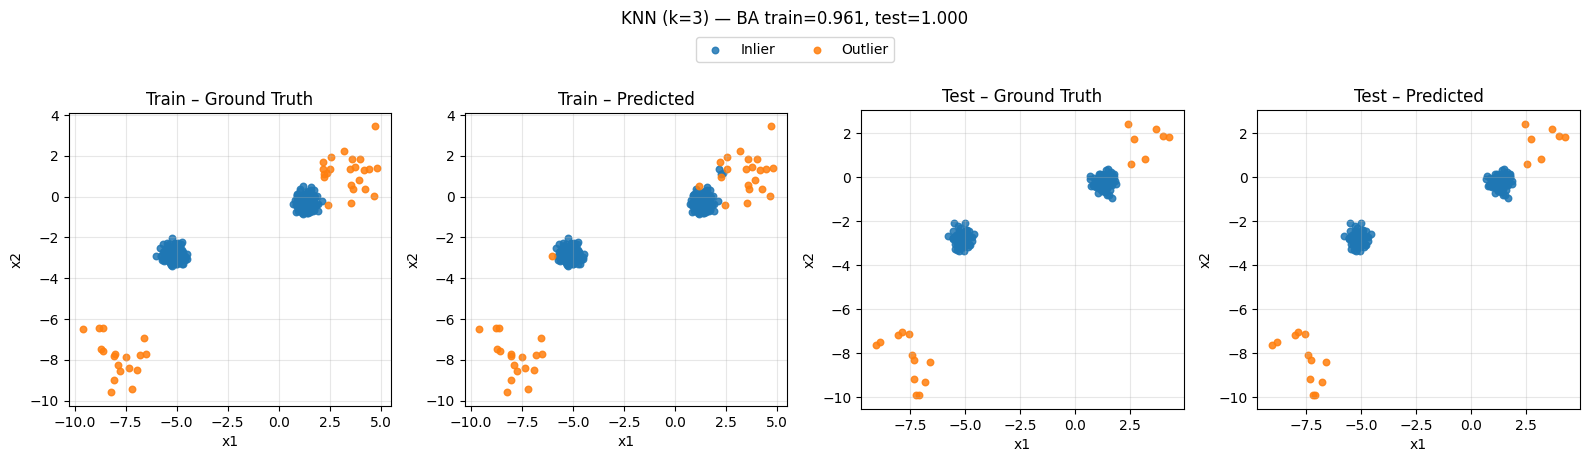

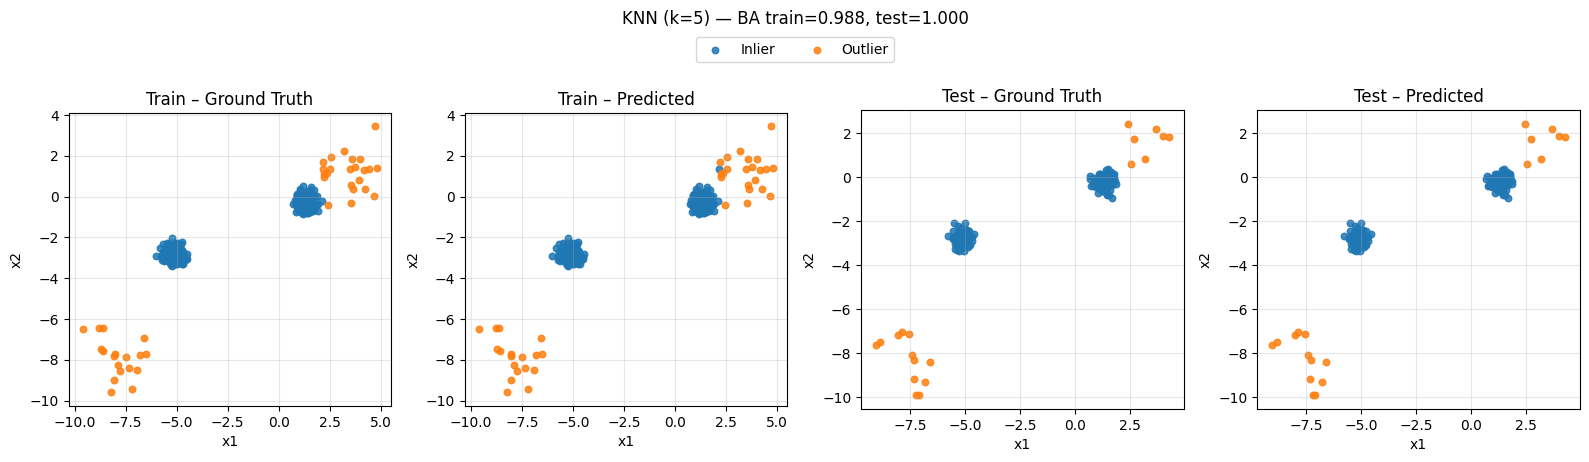

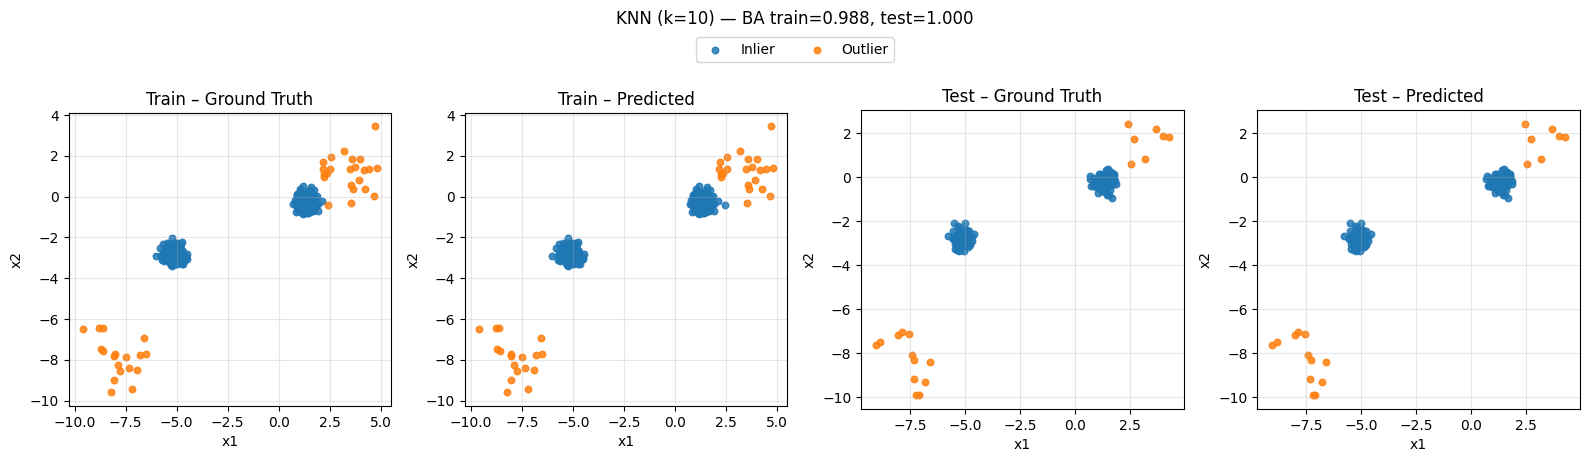

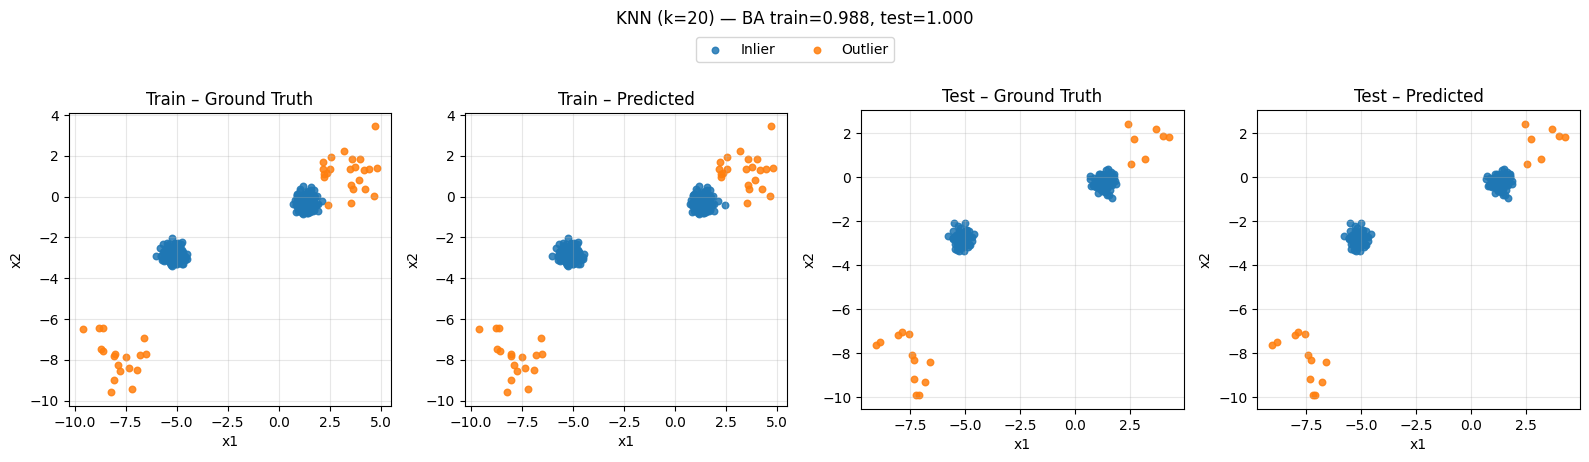

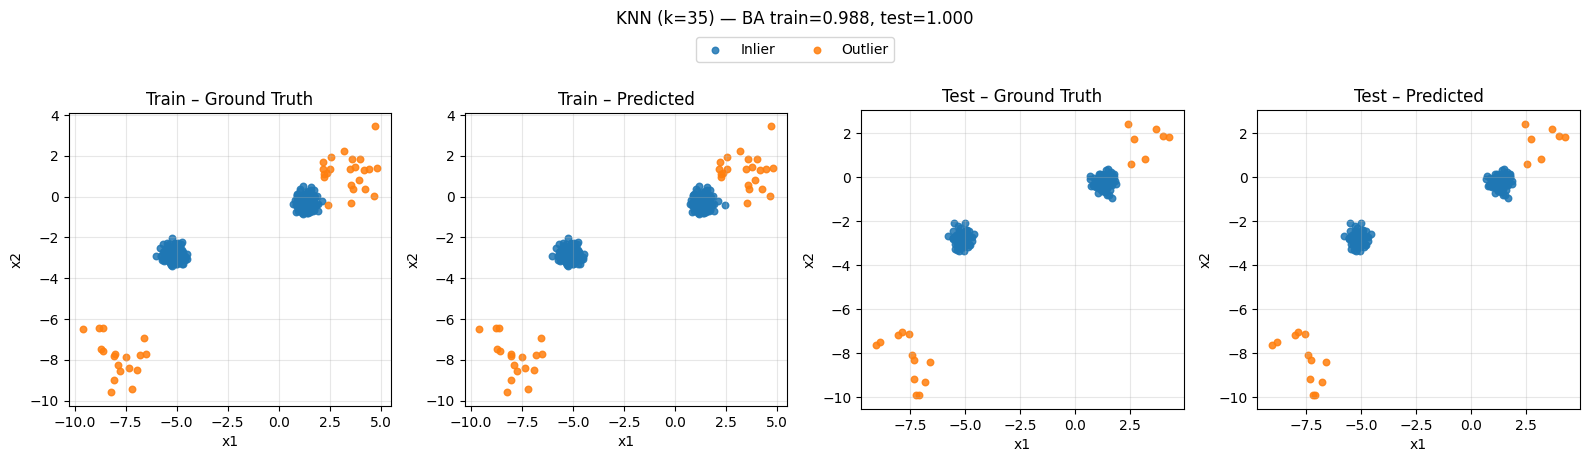

In [9]:


out = generate_data_clusters(
    n_train=400, n_test=200,
    n_clusters=2, n_features=2,
    contamination=0.1,
    size='same', density='same', dist=0.25,
    random_state=42, return_in_clusters=False
)


print(len(out))
arrays2d = [a for a in out if isinstance(a, np.ndarray) and a.ndim == 2 and a.shape[1] ==2]
arrays1d = [a for a in out if isinstance(a, np.ndarray) and a.ndim == 1]

def pick_by_len(cands, target_len):
    for a in cands:
        if len(a) == target_len:
            return a
    return None

X_train = pick_by_len(arrays2d, 400)
X_test  = pick_by_len(arrays2d, 200)

y_train = pick_by_len(arrays1d, len(X_train))
y_test  = pick_by_len(arrays1d, len(X_test))
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
assert len(X_train) == len(y_train), "X_train și y_train au lungimi diferite!"
assert len(X_test)  == len(y_test),  "X_test și y_test au lungimi diferite!"

perm_tr = np.random.permutation(len(X_train))
perm_te = np.random.permutation(len(X_test))
X_train, y_train = X_train[perm_tr], y_train[perm_tr]
X_test,  y_test  = X_test[perm_te],  y_test[perm_te]


def plot_four(axs, Xtr, ytr_true, ytr_pred, Xte, yte_true, yte_pred, title=""):
    ax_tr_true, ax_tr_pred, ax_te_true, ax_te_pred = axs
    s = 22
    def _sc(ax, X, y):
        ax.scatter(X[y==0,0], X[y==0,1], s=s, alpha=0.85, label="Inlier")
        ax.scatter(X[y==1,0], X[y==1,1], s=s, alpha=0.85, label="Outlier")
        ax.grid(True, alpha=0.3); ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax_tr_true.set_title("Train – Ground Truth"); _sc(ax_tr_true, Xtr, ytr_true)
    ax_tr_pred.set_title("Train – Predicted");    _sc(ax_tr_pred, Xtr, ytr_pred)
    ax_te_true.set_title("Test – Ground Truth");  _sc(ax_te_true, Xte, yte_true)
    ax_te_pred.set_title("Test – Predicted");     _sc(ax_te_pred, Xte, yte_pred)
    h, l = ax_tr_true.get_legend_handles_labels()
    axs[0].figure.legend(h, l, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.05))
    if title: axs[0].figure.suptitle(title, y=1.10, fontsize=12)
neighbor_list = [3, 5, 10, 20, 35]
results = []

for k in neighbor_list:
    clf = KNN(n_neighbors=k, contamination=0.1)
    clf.fit(X_train)
    y_pred_tr = clf.labels_
    y_pred_te = clf.predict(X_test)
    ba_tr = balanced_accuracy_score(y_train, y_pred_tr)
    ba_te = balanced_accuracy_score(y_test,  y_pred_te)
    results.append((k, ba_tr, ba_te))

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    plot_four(axs, X_train, y_train, y_pred_tr, X_test, y_test, y_pred_te,
              title=f"KNN (k={k}) — BA train={ba_tr:.3f}, test={ba_te:.3f}")
    plt.tight_layout(); plt.show()
    

